In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import time 
from sklearn.preprocessing import StandardScaler

from config import shuffled_csv, path_exps
from NN import NN_model, MSE, L1_reg, ReLU
from NN.utility import batch_train, batch_out, Model_Wrapper
from LevelMethod import LevelMethod
from adam import adam_SGD
from testing import multi_run

data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:100, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], ReLU, MSE)
model.init_weights()
reg_loss = L1_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights


In [2]:
import seaborn as sns

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod() ** (1.0 / len(a))

def pair_vector(vector_list):
    maxlen = len(max(vector_list, key=len))
    for i in range(len(vector_list)):
        lastEl = len(vector_list[i]) - 1
        tmpArray = np.full((maxlen - lastEl - 1, 1), vector_list[i][lastEl])
        vector_list[i] = np.array(np.concatenate((vector_list[i], tmpArray), axis=None))
    return vector_list

runs = 3
max_feval = 5000

bundle_f_values = []
bundle_runtimes = []
bundle_f_evals = []
bundle_f_times = []

adam_f_values = []
adam_runtimes = []
adam_f_evals = []
adam_f_times = []

for i in range(runs):
    print(f"Level run {i+1}")
    solver = LevelMethod(lambda_=0.7, bounds=1, max_iter=max_feval, verbose=False)
    model.init_weights()
    x = model.Weights

    start_time = time.process_time()
    status = solver.solve(f, x)
    end_time = time.process_time()
    runtime = end_time-start_time
    bundle_runtimes.append(runtime)
    bundle_f_times.append(solver.times["step"])
    bundle_f_values.append(solver.f_values)

for i in range(runs):
    solver = adam_SGD(max_feval = max_feval*2)
    model.init_weights()
    x = model.Weights

    start_time = time.process_time()
    status = solver.solve(f, x)
    end_time = time.process_time()
    runtime = end_time-start_time
    adam_runtimes.append(runtime)
    adam_f_times.append(solver.time_evaluations)
    adam_f_evals.append(solver.feval)
    adam_f_values.append(solver.f_values)

print("Solver \t\tMean runtime\t\tstandard deviation runtime")
print(f"Level Bundle\t\t{np.mean(bundle_runtimes)}\t{np.std(bundle_runtimes)}")
print(f"Adam\t\t{np.mean(adam_runtimes)}\t{np.std(adam_runtimes)}")

Level run 0
Level run 1
Level run 2
Solver 		Mean runtime		standard deviation runtime
Level Bundle		2026.5572916666667	923.1182261738513
Adam		121.609375	0.4246628564716564


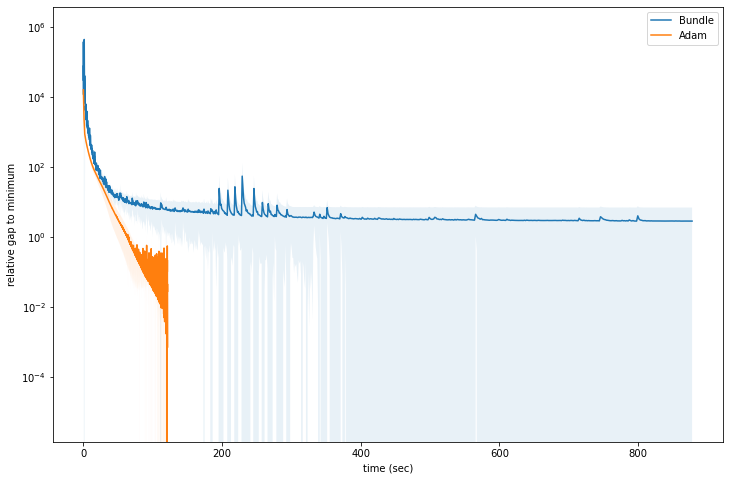

In [10]:
bundle_incremental_times = [list(np.cumsum(step_times)) for step_times in bundle_f_times]

if bundle_f_values is not None and adam_f_values is not None: 
    run_1 = pair_vector(bundle_f_values)
    run_2 = pair_vector(adam_f_values)
    df_1 = pd.DataFrame(run_1).melt()
    df_1['function'] = ["bundle"] * len(df_1.index)
    df_2 = pd.DataFrame(run_2).melt()
    df_2['function'] = ["adam"] * len(df_2.index)
    time_1 = pair_vector(bundle_incremental_times)
    time_2 = pair_vector(adam_f_times)
    df_3 = pd.DataFrame(time_1).melt()
    df_3['function'] = ["bundle"] * len(df_3.index)
    df_4 = pd.DataFrame(time_2).melt()
    df_4['function'] = ["adam"] * len(df_4.index)
    X1 = []
    Y1 = []
    y1_std = []
    X2 = []
    Y2 = []
    y2_std = []

    for i in range(0,len(df_1["value"].to_numpy()),runs):
        X1.append(np.mean(df_3["value"].to_numpy()[i:i+runs]))
        Y1.append(np.mean(df_1["value"].to_numpy()[i:i+runs]))
        y1_std.append(np.std(df_1["value"].to_numpy()[i:i+runs]))

    for i in range(0,len(df_2["value"].to_numpy()),runs):
        X2.append(np.mean(df_4["value"].to_numpy()[i:i+runs]))
        Y2.append(np.mean(df_2["value"].to_numpy()[i:i+runs]))
        y2_std.append(np.std(df_2["value"].to_numpy()[i:i+runs]))

    f_star = min(min(Y1),min(Y2))
    for i in range(len(Y1)):
        Y1[i] = (Y1[i] - f_star) / f_star
        y1_std[i] = y1_std[i]/f_star
    for i in range(len(Y2)):
        Y2[i] = (Y2[i] - f_star) / f_star
        y2_std[i] = y2_std[i]/f_star
    
    # Plot fevals
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(np.asarray(X1)-X1[0],Y1, label='Bundle')
    ax.fill_between(np.asarray(X1)-X1[0], np.asarray(Y1)-np.asarray(y1_std),np.asarray(Y1)+np.asarray(y1_std),alpha=0.1,interpolate = True)
    ax.plot(np.asarray(X2)-X2[0],Y2, label='Adam')
    ax.fill_between(np.asarray(X2)-X2[0], np.asarray(Y2)-np.asarray(y2_std),np.asarray(Y2)+np.asarray(y2_std),alpha=0.1,interpolate = True)
    plt.yscale("log")
    plt.legend()
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('relative gap to minimum')

    plt.savefig('plots/level/comparison_adam_bundle.png')

<Figure size 432x288 with 0 Axes>